# Estimating the $\beta$ parameter for the Confidence Regions

In [179]:
library(mvtnorm, warn.conflicts = FALSE)
library(sf, warn.conflicts = FALSE)
library(sfheaders, warn.conflicts = FALSE)
library(purrr, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source('/global/u1/j/jbbutler/isolines_uq/scripts/R/confidenceRegions.R')
source('/global/u1/j/jbbutler/isolines_uq/scripts/R/utils.R')

First, setting hyperparameters

In [180]:
n <- 3000
B <- 500
alpha <- 0.05
p <- 0.01
asympIndep <- FALSE
n_iter <- 500

lb <- -5
ub <- 5
gticks <- 250

est_gsize <- 500
grid <- expand.grid(X1 = seq(lb, ub, length.out = gticks),
                    X2 = seq(lb, ub, length.out = gticks))
boot_gsize = 100

Making the sf object for the isoline, and extending it to the full extent of the grid if necessary

In [181]:
if (asympIndep) {
    isoline <- readRDS(paste0('/global/cscratch1/sd/jbbutler/isolines/bivariate_gaussian/', p, '_bivgauss.RData'))
} else {
    isoline <- readRDS(paste0('/global/cscratch1/sd/jbbutler/isolines/bivariate_t/', p, '_bivt.RData'))
}

if (min(isoline$X1) > lb | min(isoline$X2) > lb) {
    isoline_multi <- extendIsoline(isoline, lb)
} else {
    isoline_multi <- sfg_multilinestring(isoline)
}


Generating the data and the extent

In [182]:
if (asympIndep) {
        dat <- data.frame(rmvnorm(n, mean = rep(0, 2), sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2)))
        suffix <- 'bivgauss_confregs'
    } else {
        dat <- data.frame(rmvt(n, sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4))
        suffix <- 'bivt_confregs'
    }

xmin <- c(min(min(dat$X1), lb), min(min(dat$X2), lb))
xmax <- c(max(max(dat$X1), ub), max(max(dat$X2), ub))

Choosing the mesh of $\beta$ to try

In [183]:
betas <- seq(1, 1000, by = 10)/10000
# define anything within 10^-5 of zero to be beta = 0, do not choose beta smaller than this number!!
# choose this such that there are still data points that meet this criterion
# will never exactly 
beta_zero <- 10^-5

Drawing the survival function

In [184]:
surv_func <- kcde(dat, tail.flag = 'upper', gridsize = est_gsize, eval.points = grid, xmin = xmin, xmax = xmax)

Storing all of the bootstrap replicates of $f^{*}_{n}(x) = |\hat{h}_{n}^{*}(x) - \hat{h}_{n}(x)|$

In [185]:
boot_diffs <- vector(mode = 'list', length = B)

for (i in 1:B) {
    
    boot_samp <- dat %>% sample_frac(1, replace = TRUE)
    boot_surv_func <- kcde(boot_samp, eval.points = grid, gridsize = boot_gsize,
                               tail.flag = 'upper', xmin = xmin, xmax = xmax)
    boot_diffs[[i]] <- abs(surv_func$estimate - boot_surv_func$estimate)
    
}


Function that estimates the padding on the lower and upper bounds of the probability of the coverage event, where the padding is defined by anything that is not $1-\alpha$

In [186]:
estimateBoundPadding <- function(beta, beta_zero, surv_func, boot_diffs, p, alpha) {
    
    getZ <- function(beta, surv_func, p, boot_diffs) {
    deltamask <- abs(-surv_func$estimate + p) <= beta
    return(max(boot_diffs[deltamask]))
    }
    
    Z0s <- map(boot_diffs, getZ, beta = beta_zero, surv_func = surv_func, p = p)
    
    probAnC <- mean(map(boot_diffs, max) > beta)
    Zbetas <- map_dbl(boot_diffs, getZ, beta = beta, surv_func = surv_func, p = p)
    bhat <- quantile(Zbetas, prob = 1 - alpha)[[1]]
    
    ts <- seq(min(Zbetas), max(Zbetas), length.out = 1000)

    e <- ecdf(Zbetas)

    lower_bool <- e(ts) <= 1-alpha
    upper_bool <- e(ts) >= 1-alpha

    bplus <- ts[lower_bool][which.max(e(ts)[lower_bool])]
    bminus <- ts[upper_bool][which.min(e(ts)[upper_bool])]
    
    pn <- mean(Zbetas <= bhat)
    FZn_bplus <- mean(Zbetas <= bplus)
    pn0 <- mean(Z0s <= bhat)
    FZn_bminus <- mean(Zbetas <= bminus)
    
    ub_padding <- pn0 - FZn_bminus
    lb_padding <- pn - FZn_bplus - probAnC
    
    return(c(lb_padding, ub_padding))
}



Get the lower and upper bound paddings for each $\beta$

In [187]:
res <- map(betas, estimateBoundPadding, beta_zero=beta_zero, surv_func=surv_func, boot_diffs=boot_diffs, p=p, alpha=alpha)

In [188]:
res <- do.call(rbind, res)

In [189]:
res <- data.frame(res)
colnames(res) <- c('lower_pad', 'upper_pad')
res <- mutate(res, betas = betas, lower_bound = res$lower_pad + (1-alpha), upper_bound = res$upper_pad + (1-alpha))

### Result

Seems like $\beta$ has to be quite low to even get the upper bound to go down. In practice, the upper bound may actually smaller for larger $\beta$ than these results are letting on, but not super informative for choosing $\beta$. I know these bounds are pretty loose (at least the bootstrap computed bounds are), since even for $\beta = 0.018 = 1/\sqrt{3000}$, we observed coverage greater than $-0.05$.

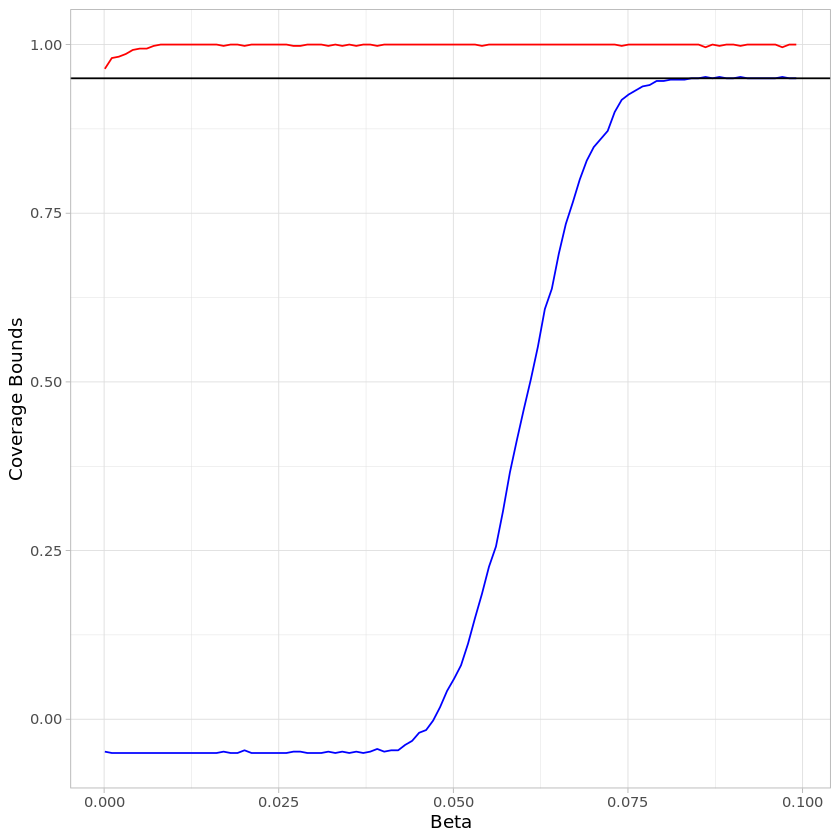

In [190]:
ggplot(res) + geom_line(aes(x = betas, y = lower_bound), color = 'blue') + geom_line(aes(x = betas, y = upper_bound), color = 'red') + geom_hline(aes(yintercept = 0.95)) + xlab('Beta') + ylab('Coverage Bounds') + theme_light()





In [191]:
#the beta we would choose that minimizes the euclidean distance of the errors from 0

betas[which.min(sqrt(res$lower_pad**2 + res$upper_pad**2))]

[1] 0.0861

Note that this $\beta$ is slightly smaller than the $\beta$ we would have chosen if we did $\beta(n) = 1/n^{1/3}$, which I think performed the best among all the beta functions I had tried earlier..

Takeaway: not sure how to use this result could be used to informatively choose a $\beta$, since from the plot it seems like there is no $\beta$ that reduces both the upper bound and lower bound simultaneously (maybe due to the looseness in the estimated bounds, but based on previous knowledge/experience the bounds are not incorrect).

Something tells me that we should actually be using different bootstrap samples to do the estimation of the quantities and then estimating the probabilities, so let's try that out...

#### What if we tried to make the plot of the bounds (as a function of $\beta$) for a bunch of different sample sizes $n$?

In [192]:
n <- 10000

In [193]:
if (asympIndep) {
        dat <- data.frame(rmvnorm(n, mean = rep(0, 2), sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2)))
        suffix <- 'bivgauss_confregs'
    } else {
        dat <- data.frame(rmvt(n, sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4))
        suffix <- 'bivt_confregs'
    }

xmin <- c(min(min(dat$X1), lb), min(min(dat$X2), lb))
xmax <- c(max(max(dat$X1), ub), max(max(dat$X2), ub))

In [194]:
betas <- seq(1, 1000, by = 10)/10000
# define anything within 10^-5 of zero to be beta = 0, do not choose beta smaller than this number!!
# choose this such that there are still data points that meet this criterion
# will never exactly 
beta_zero <- 10^-5

In [195]:
surv_func <- kcde(dat, tail.flag = 'upper', gridsize = est_gsize, eval.points = grid, xmin = xmin, xmax = xmax)

In [196]:
boot_diffs <- vector(mode = 'list', length = B)

for (i in 1:B) {
    
    boot_samp <- dat %>% sample_frac(1, replace = TRUE)
    boot_surv_func <- kcde(boot_samp, eval.points = grid, gridsize = boot_gsize,
                               tail.flag = 'upper', xmin = xmin, xmax = xmax)
    boot_diffs[[i]] <- abs(surv_func$estimate - boot_surv_func$estimate)
    
}

In [197]:
res <- map(betas, estimateBoundPadding, beta_zero=beta_zero, surv_func=surv_func, boot_diffs=boot_diffs, p=p, alpha=alpha)
res <- do.call(rbind, res)
res <- data.frame(res)
colnames(res) <- c('lower_pad', 'upper_pad')
res <- mutate(res, betas = betas, lower_bound = res$lower_pad + (1-alpha), upper_bound = res$upper_pad + (1-alpha))

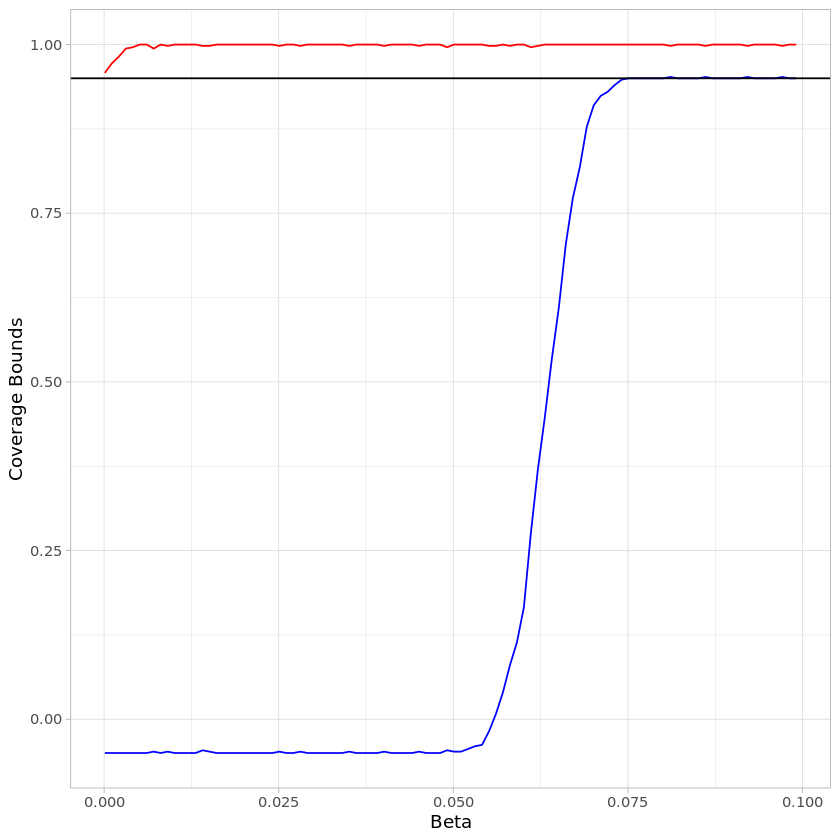

In [198]:
ggplot(res) + geom_line(aes(x = betas, y = lower_bound), color = 'blue') + geom_line(aes(x = betas, y = upper_bound), color = 'red') + geom_hline(aes(yintercept = 0.95)) + xlab('Beta') + ylab('Coverage Bounds') + theme_light()

Became a little bit more steep... Maybe a good sign?

In [199]:
n <- 20000

In [200]:
if (asympIndep) {
        dat <- data.frame(rmvnorm(n, mean = rep(0, 2), sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2)))
        suffix <- 'bivgauss_confregs'
    } else {
        dat <- data.frame(rmvt(n, sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4))
        suffix <- 'bivt_confregs'
    }

xmin <- c(min(min(dat$X1), lb), min(min(dat$X2), lb))
xmax <- c(max(max(dat$X1), ub), max(max(dat$X2), ub))

In [201]:
betas <- seq(1, 1000, by = 10)/10000
# define anything within 10^-5 of zero to be beta = 0, do not choose beta smaller than this number!!
# choose this such that there are still data points that meet this criterion
# will never exactly 
beta_zero <- 10^-5

In [202]:
surv_func <- kcde(dat, tail.flag = 'upper', gridsize = est_gsize, eval.points = grid, xmin = xmin, xmax = xmax)

In [203]:
boot_diffs <- vector(mode = 'list', length = B)

for (i in 1:B) {
    
    boot_samp <- dat %>% sample_frac(1, replace = TRUE)
    boot_surv_func <- kcde(boot_samp, eval.points = grid, gridsize = boot_gsize,
                               tail.flag = 'upper', xmin = xmin, xmax = xmax)
    boot_diffs[[i]] <- abs(surv_func$estimate - boot_surv_func$estimate)
    
}

In [204]:
res <- map(betas, estimateBoundPadding, beta_zero=beta_zero, surv_func=surv_func, boot_diffs=boot_diffs, p=p, alpha=alpha)
res <- do.call(rbind, res)
res <- data.frame(res)
colnames(res) <- c('lower_pad', 'upper_pad')
res <- mutate(res, betas = betas, lower_bound = res$lower_pad + (1-alpha), upper_bound = res$upper_pad + (1-alpha))

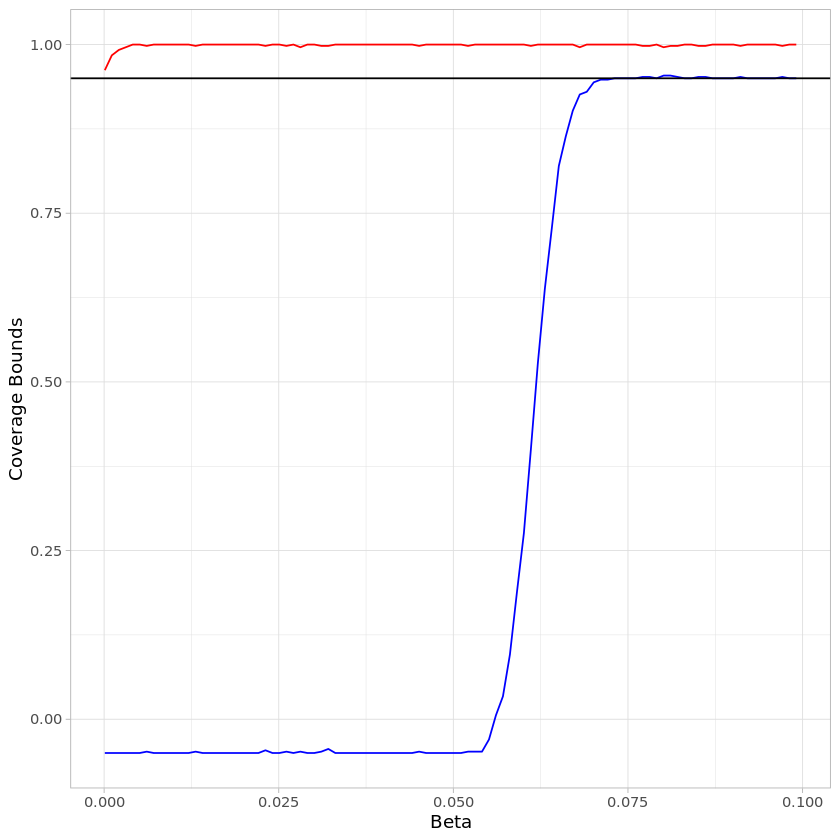

In [205]:
ggplot(res) + geom_line(aes(x = betas, y = lower_bound), color = 'blue') + geom_line(aes(x = betas, y = upper_bound), color = 'red') + geom_hline(aes(yintercept = 0.95)) + xlab('Beta') + ylab('Coverage Bounds') + theme_light()


In [213]:
n <- 30000

In [214]:
if (asympIndep) {
        dat <- data.frame(rmvnorm(n, mean = rep(0, 2), sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2)))
        suffix <- 'bivgauss_confregs'
    } else {
        dat <- data.frame(rmvt(n, sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4))
        suffix <- 'bivt_confregs'
    }

xmin <- c(min(min(dat$X1), lb), min(min(dat$X2), lb))
xmax <- c(max(max(dat$X1), ub), max(max(dat$X2), ub))

In [215]:
betas <- seq(1, 1000, by = 10)/10000
# define anything within 10^-5 of zero to be beta = 0, do not choose beta smaller than this number!!
# choose this such that there are still data points that meet this criterion
# will never exactly 
beta_zero <- 10^-5

In [216]:
surv_func <- kcde(dat, tail.flag = 'upper', gridsize = est_gsize, eval.points = grid, xmin = xmin, xmax = xmax)

In [217]:
boot_diffs <- vector(mode = 'list', length = B)

for (i in 1:B) {
    
    boot_samp <- dat %>% sample_frac(1, replace = TRUE)
    boot_surv_func <- kcde(boot_samp, eval.points = grid, gridsize = boot_gsize,
                               tail.flag = 'upper', xmin = xmin, xmax = xmax)
    boot_diffs[[i]] <- abs(surv_func$estimate - boot_surv_func$estimate)
    
}

In [218]:
res <- map(betas, estimateBoundPadding, beta_zero=beta_zero, surv_func=surv_func, boot_diffs=boot_diffs, p=p, alpha=alpha)
res <- do.call(rbind, res)
res <- data.frame(res)
colnames(res) <- c('lower_pad', 'upper_pad')
res <- mutate(res, betas = betas, lower_bound = res$lower_pad + (1-alpha), upper_bound = res$upper_pad + (1-alpha))

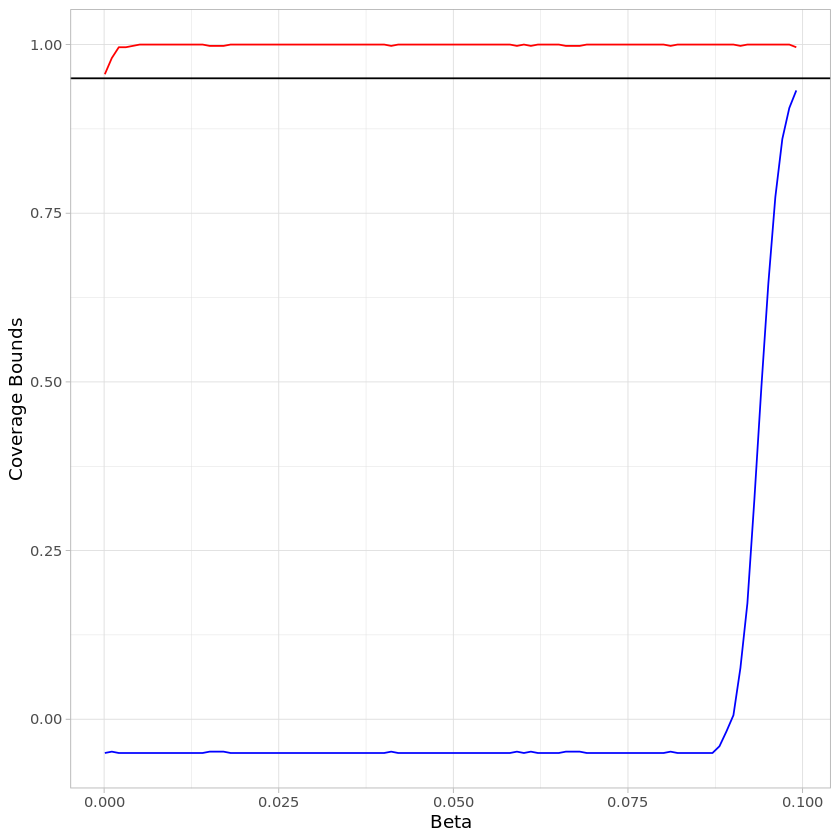

In [219]:
ggplot(res) + geom_line(aes(x = betas, y = lower_bound), color = 'blue') + geom_line(aes(x = betas, y = upper_bound), color = 'red') + geom_hline(aes(yintercept = 0.95)) + xlab('Beta') + ylab('Coverage Bounds') + theme_light()


Bound pushes to the right, what is happening here? Expected to shift to the left since as you increase your sample size, your confidence regions to achieve $(1-\alpha)*100\%$ coverage should be smaller, and so the $\beta$ required to achieve at least 95% coverage should also be getting smaller

### 2 separate bootstrap procedures

In [29]:
n <- 3000
B <- 1000
alpha <- 0.05
p <- 0.01
asympIndep <- FALSE
n_iter <- 500

lb <- -5
ub <- 5
gticks <- 250

est_gsize <- 500
grid <- expand.grid(X1 = seq(lb, ub, length.out = gticks),
                    X2 = seq(lb, ub, length.out = gticks))
boot_gsize = 100

In [30]:
if (asympIndep) {
    isoline <- readRDS(paste0('/global/cscratch1/sd/jbbutler/isolines/bivariate_gaussian/', p, '_bivgauss.RData'))
} else {
    isoline <- readRDS(paste0('/global/cscratch1/sd/jbbutler/isolines/bivariate_t/', p, '_bivt.RData'))
}

if (min(isoline$X1) > lb | min(isoline$X2) > lb) {
    isoline_multi <- extendIsoline(isoline, lb)
} else {
    isoline_multi <- sfg_multilinestring(isoline)
}

In [31]:
if (asympIndep) {
        dat <- data.frame(rmvnorm(n, mean = rep(0, 2), sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2)))
        suffix <- 'bivgauss_confregs'
    } else {
        dat <- data.frame(rmvt(n, sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4))
        suffix <- 'bivt_confregs'
    }

xmin <- c(min(min(dat$X1), lb), min(min(dat$X2), lb))
xmax <- c(max(max(dat$X1), ub), max(max(dat$X2), ub))

In [32]:
betas <- seq(1, 750, by = 10)/10000
# define anything within 10^-5 of zero to be beta = 0, do not choose beta smaller than this number!!
# choose this such that there are still data points that meet this criterion
# will never exactly 
beta_zero <- 10^-5

In [33]:
surv_func <- kcde(dat, tail.flag = 'upper', gridsize = est_gsize, eval.points = grid, xmin = xmin, xmax = xmax)

In [34]:
boot_diffs_1 <- vector(mode = 'list', length = B/2)
boot_diffs_2 <- vector(mode = 'list', length = B/2)

for (i in 1:(B/2)) {
    
    boot_samp_1 <- dat %>% sample_frac(1, replace = TRUE)
    boot_samp_2 <- dat %>% sample_frac(1, replace = TRUE)
    boot_surv_func_1 <- kcde(boot_samp_1, eval.points = grid, gridsize = boot_gsize,
                               tail.flag = 'upper', xmin = xmin, xmax = xmax)
    boot_surv_func_2 <- kcde(boot_samp_2, eval.points = grid, gridsize = boot_gsize,
                               tail.flag = 'upper', xmin = xmin, xmax = xmax)
    boot_diffs_1[[i]] <- abs(surv_func$estimate - boot_surv_func_1$estimate)
    boot_diffs_2[[i]] <- abs(surv_func$estimate - boot_surv_func_2$estimate)
    
}


In [35]:
estimateQuantities <- function(beta, surv_func, boot_diffs, p, alpha) {
    
    getZ <- function(beta, surv_func, p, boot_diffs) {
    deltamask <- abs(-surv_func$estimate + p) <= beta
    return(max(boot_diffs[deltamask]))
    }
    
    Zbetas <- map_dbl(boot_diffs, getZ, beta = beta, surv_func = surv_func, p = p)
    bhat <- quantile(Zbetas, prob = 1 - alpha)[[1]]
    
    ts <- seq(min(Zbetas), max(Zbetas), length.out = 1000)
    e <- ecdf(Zbetas)
    
    lower_bool <- e(ts) <= 1-alpha
    upper_bool <- e(ts) >= 1-alpha

    bplus <- ts[lower_bool][which.max(e(ts)[lower_bool])]
    bminus <- ts[upper_bool][which.min(e(ts)[upper_bool])]
    
    return(c(beta, bhat, bminus, bplus))
    
}

In [36]:
vals <- map(betas, estimateQuantities, surv_func=surv_func, boot_diffs=boot_diffs_1, p=p, alpha=alpha)

In [37]:
estimateBounds <- function(quantities, surv_func, beta_zero, boot_diffs, p, alpha) {
    
    getZ <- function(beta, surv_func, p, boot_diffs) {
    deltamask <- abs(-surv_func$estimate + p) <= beta
    return(max(boot_diffs[deltamask]))
    }
    
    beta <- quantities[1]
    bhat <- quantities[2]
    bminus <- quantities[3]
    bplus <- quantities[4]
    
    Z0s <- map(boot_diffs, getZ, beta = beta_zero, surv_func = surv_func, p = p)
    probAnC <- mean(map(boot_diffs, max) > beta)
    Zbetas <- map_dbl(boot_diffs, getZ, beta = beta, surv_func = surv_func, p = p)    
    
    pn <- mean(Zbetas <= bhat)
    FZn_bplus <- mean(Zbetas <= bplus)
    pn0 <- mean(Z0s <= bhat)
    FZn_bminus <- mean(Zbetas <= bminus)
    
    ub_padding <- pn0 - FZn_bminus
    lb_padding <- pn - FZn_bplus - probAnC
    
    return(c(lb_padding, ub_padding))
    
    
}

In [38]:
res <- map(vals, estimateBounds, beta_zero=beta_zero, surv_func=surv_func, boot_diffs=boot_diffs_2, p=p, alpha=alpha)



In [39]:
res <- do.call(rbind, res)
res <- data.frame(res)
colnames(res) <- c('lower_pad', 'upper_pad')
res <- mutate(res, betas = betas, lower_bound = res$lower_pad + (1-alpha), upper_bound = res$upper_pad + (1-alpha))

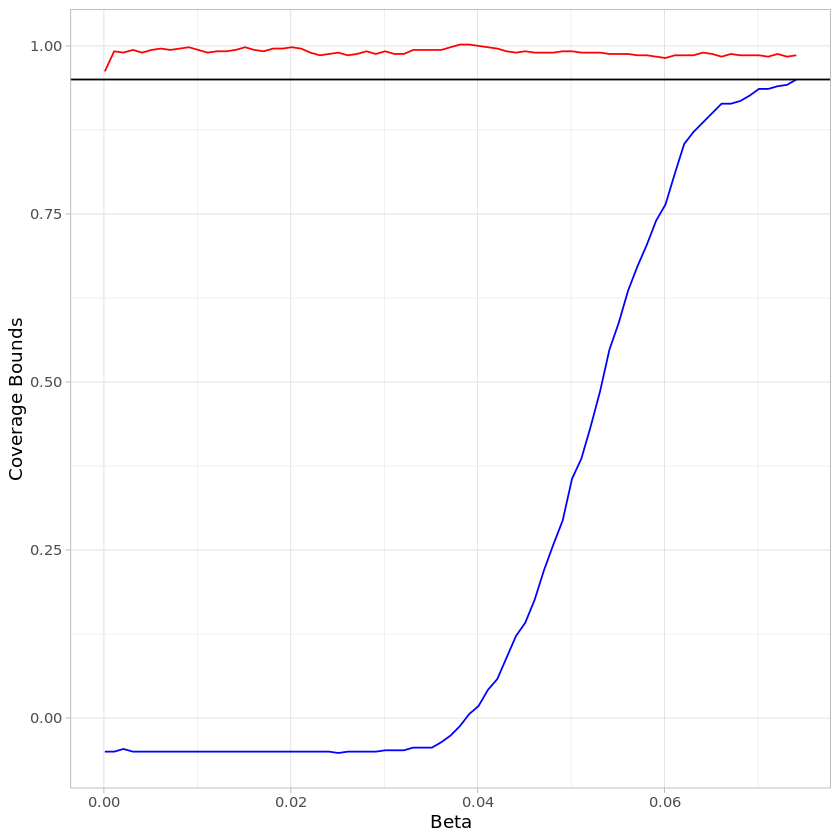

In [40]:
ggplot(res) + geom_line(aes(x = betas, y = lower_bound), color = 'blue') + geom_line(aes(x = betas, y = upper_bound), color = 'red') + geom_hline(aes(yintercept = 0.95)) + xlab('Beta') + ylab('Coverage Bounds') + theme_light()


In [41]:
betas[which.min(sqrt(res$lower_pad**2 + res$upper_pad**2))]

[1] 0.0731

Seems different than the case where we only used a single frozen set of bootstrap samples, but it's clear it's performing worse/not particularly more informative, since the upper bound is basically above 1. Should check for any bugs, but if it seems like there are none, I don't think it's worth messing with the upper bound. Try to choose the smallest $\beta$ that still achieves a sufficient lower bound for undercoverage so as to make the interval the thinnest, and go from there (under the assumption that it's better to over-cover than undercover) 

### Experimenting with Something More Efficient Than Line-Searches

Maybe using `optimize` in R?
What about `uniroot` to find the roots?

Issue this that we might settle on local minima, since it seems that global optimization is not guaranteed.

In [10]:
n <- 3000
B <- 500
alpha <- 0.05
p <- 0.01
asympIndep <- FALSE
n_iter <- 500

lb <- -5
ub <- 5
gticks <- 250

est_gsize <- 500
grid <- expand.grid(X1 = seq(lb, ub, length.out = gticks),
                    X2 = seq(lb, ub, length.out = gticks))
boot_gsize = 100

In [12]:
if (asympIndep) {
    isoline <- readRDS(paste0('/global/cscratch1/sd/jbbutler/isolines/bivariate_gaussian/', p, '_bivgauss.RData'))
} else {
    isoline <- readRDS(paste0('/global/cscratch1/sd/jbbutler/isolines/bivariate_t/', p, '_bivt.RData'))
}

if (min(isoline$X1) > lb | min(isoline$X2) > lb) {
    isoline_multi <- extendIsoline(isoline, lb)
} else {
    isoline_multi <- sfg_multilinestring(isoline)
}

In [11]:
if (asympIndep) {
        dat <- data.frame(rmvnorm(n, mean = rep(0, 2), sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2)))
        suffix <- 'bivgauss_confregs'
    } else {
        dat <- data.frame(rmvt(n, sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4))
        suffix <- 'bivt_confregs'
    }

xmin <- c(min(min(dat$X1), lb), min(min(dat$X2), lb))
xmax <- c(max(max(dat$X1), ub), max(max(dat$X2), ub))

In [13]:
surv_func <- kcde(dat, tail.flag = 'upper', gridsize = est_gsize, eval.points = grid, xmin = xmin, xmax = xmax)

In [14]:
boot_diffs <- vector(mode = 'list', length = B)

for (i in 1:B) {
    
    boot_samp <- dat %>% sample_frac(1, replace = TRUE)
    boot_surv_func <- kcde(boot_samp, eval.points = grid, gridsize = boot_gsize,
                               tail.flag = 'upper', xmin = xmin, xmax = xmax)
    boot_diffs[[i]] <- abs(surv_func$estimate - boot_surv_func$estimate)
    
}

In [17]:
computeUpperPadding <- function(beta, beta_zero, surv_func, boot_diffs, p, alpha) {
    
    getZ <- function(beta, surv_func, p, boot_diffs) {
    deltamask <- abs(-surv_func$estimate + p) <= beta
    return(max(boot_diffs[deltamask]))
    }
    
    Z0s <- map(boot_diffs, getZ, beta = beta_zero, surv_func = surv_func, p = p)
    
    Zbetas <- map_dbl(boot_diffs, getZ, beta = beta, surv_func = surv_func, p = p)
    bhat <- quantile(Zbetas, prob = 1 - alpha)[[1]]
    
    ts <- seq(min(Zbetas), max(Zbetas), length.out = 1000)
    e <- ecdf(Zbetas)

    lower_bool <- e(ts) <= 1-alpha
    upper_bool <- e(ts) >= 1-alpha

    bminus <- ts[upper_bool][which.min(e(ts)[upper_bool])]
    
    pn0 <- mean(Z0s <= bhat)
    FZn_bminus <- mean(Zbetas <= bminus)
    
    ub_padding <- pn0 - FZn_bminus
    
    return(ub_padding)
    
}

In [18]:
beta_zero = 1e-5

In [12]:
optim_res <- optimize(f=computeUpperPadding, interval=c(beta_zero, 0.01), beta_zero=beta_zero, 
         surv_func=surv_func, boot_diffs=boot_diffs, p=p, alpha=alpha, maximum = FALSE, tol = 0.001)

In [100]:
beta_min <- optim_res$minimum

In [118]:
a <- readRDS('/global/cscratch1/sd/jbbutler/sims/regions/bases_betachoice/3000n_500B_0.01pbase_beta_upperoptimbivt_confregs/1_3000n_500B_0.01pbase_beta_upperoptimbivt_confregs.RData')


Trying out some root-finding methods to find $\beta$ (NOTE: took the absolute value out of the answer)

In [23]:
res <- uniroot(f=computeUpperPadding, interval=c(beta_zero, 0.01), beta_zero=beta_zero, surv_func=surv_func, boot_diffs=boot_diffs, p=p, alpha=alpha, extendInt='downX')




In [28]:
computeUpperPadding(beta_zero, beta_zero/5, surv_func, boot_diffs, p, alpha)

[1] 0.03

Issue: doesn't really seem like the upper bound can get below $1-\alpha$...

### Exploring the Upper Bound being Less than $1-\alpha$

When does it get small??

In [46]:
n <- 3000
B <- 500
alpha <- 0.05
p <- 0.01
asympIndep <- FALSE
n_iter <- 500

lb <- -5
ub <- 5
gticks <- 250

est_gsize <- 500
grid <- expand.grid(X1 = seq(lb, ub, length.out = gticks),
                    X2 = seq(lb, ub, length.out = gticks))
boot_gsize = 100

In [47]:
if (asympIndep) {
        dat <- data.frame(rmvnorm(n, mean = rep(0, 2), sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2)))
        suffix <- 'bivgauss_confregs'
    } else {
        dat <- data.frame(rmvt(n, sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4))
        suffix <- 'bivt_confregs'
    }

xmin <- c(min(min(dat$X1), lb), min(min(dat$X2), lb))
xmax <- c(max(max(dat$X1), ub), max(max(dat$X2), ub))

In [99]:
betas <- seq(1, 100, by = 0.1)/100000
# define anything within 10^-5 of zero to be beta = 0, do not choose beta smaller than this number!!
# choose this such that there are still data points that meet this criterion
# will never exactly 
beta_zero <- 10^-5

In [100]:
surv_func <- kcde(dat, tail.flag = 'upper', gridsize = est_gsize, eval.points = grid, xmin = xmin, xmax = xmax)

In [102]:
boot_diffs <- vector(mode = 'list', length = B)

for (i in 1:B) {
    
    boot_samp <- dat %>% sample_frac(1, replace = TRUE)
    boot_surv_func <- kcde(boot_samp, eval.points = grid, gridsize = boot_gsize,
                               tail.flag = 'upper', xmin = xmin, xmax = xmax)
    boot_diffs[[i]] <- abs(surv_func$estimate - boot_surv_func$estimate)
    
}


In [103]:
estimateBoundPadding <- function(beta, beta_zero, surv_func, boot_diffs, p, alpha) {
    
    getZ <- function(beta, surv_func, p, boot_diffs) {
    deltamask <- abs(-surv_func$estimate + p) <= beta
    return(max(boot_diffs[deltamask]))
    }
    
    Z0s <- map(boot_diffs, getZ, beta = beta_zero, surv_func = surv_func, p = p)
    
    probAnC <- mean(map(boot_diffs, max) > beta)
    Zbetas <- map_dbl(boot_diffs, getZ, beta = beta, surv_func = surv_func, p = p)
    bhat <- quantile(Zbetas, prob = 1 - alpha)[[1]]
    
    ts <- seq(min(Zbetas), max(Zbetas), length.out = 1000)

    e <- ecdf(Zbetas)

    lower_bool <- e(ts) <= 1-alpha
    upper_bool <- e(ts) >= 1-alpha

    bplus <- ts[lower_bool][which.max(e(ts)[lower_bool])]
    bminus <- ts[upper_bool][which.min(e(ts)[upper_bool])]
    
    pn <- mean(Zbetas <= bhat)
    FZn_bplus <- mean(Zbetas <= bplus)
    pn0 <- mean(Z0s <= bhat)
    FZn_bminus <- mean(Zbetas <= bminus)
    
    ub_padding <- pn0 - FZn_bminus
    lb_padding <- pn - FZn_bplus - probAnC
    
    return(c(lb_padding, ub_padding))
}


In [104]:
res <- map(betas, estimateBoundPadding, beta_zero=beta_zero, surv_func=surv_func, boot_diffs=boot_diffs, p=p, alpha=alpha)

In [108]:
res1 <- do.call(rbind, res)
res1 <- data.frame(res1)
colnames(res1) <- c('lower_pad', 'upper_pad')
res1 <- mutate(res1, betas = betas, lower_bound = res1$lower_pad + (1-alpha), upper_bound = res1$upper_pad + (1-alpha))

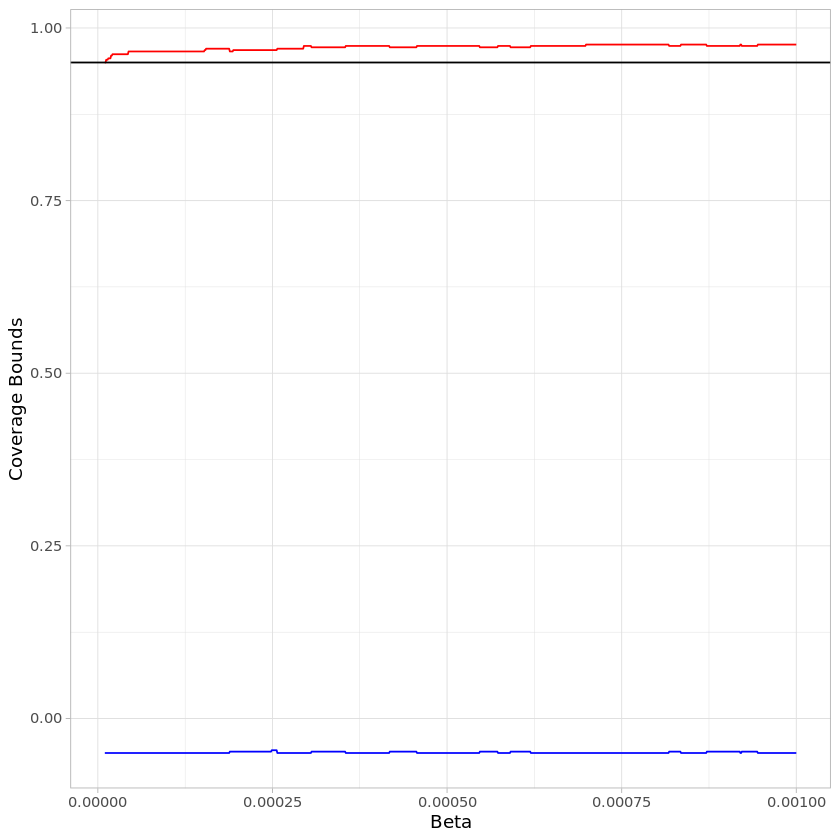

In [109]:
ggplot(res1) + geom_line(aes(x = betas, y = lower_bound), color = 'blue') + geom_line(aes(x = betas, y = upper_bound), color = 'red') + geom_hline(aes(yintercept = 0.95)) + xlab('Beta') + ylab('Coverage Bounds') + theme_light()


Eventually does get down to $0$ (takes a while, the appropriate $\beta$ seems to match the $\beta$ from $\beta_n = 1/n$, so similar to results previously observed). But a little precarious because the lower bound is literally negative, so it's a bit weird..

### More playing around

In [141]:
getZ <- function(beta, surv_func, p, boot_diffs) {
    deltamask <- abs(-surv_func$estimate + p) <= beta
    return(max(boot_diffs[deltamask]))
}

beta <- 1/1000
    
Z0s <- map(boot_diffs, getZ, beta = beta_zero, surv_func = surv_func, p = p)
    
probAnC <- mean(map(boot_diffs, max) > beta)
Zbetas <- map_dbl(boot_diffs, getZ, beta = beta, surv_func = surv_func, p = p)
bhat <- quantile(Zbetas, prob = 1 - alpha)[[1]]
    
ts <- seq(min(Zbetas), max(Zbetas), length.out = 1000)

e <- ecdf(Zbetas)

lower_bool <- e(ts) <= 1-alpha
upper_bool <- e(ts) >= 1-alpha

bplus <- ts[lower_bool][which.max(e(ts)[lower_bool])]
bminus <- ts[upper_bool][which.min(e(ts)[upper_bool])]
    
pn <- mean(Zbetas <= bhat)
FZn_bplus <- mean(Zbetas <= bplus)
pn0 <- mean(Z0s <= bhat)
FZn_bminus <- mean(Zbetas <= bminus)
    
ub_padding <- pn0 - FZn_bminus
lb_padding <- pn - FZn_bplus - probAnC